## 앙상블 기법의 종류

**배깅 (Bagging)**
- **개념**: 배깅은 부트스트랩 샘플링을 통해 여러 데이터셋을 생성하고, 각 데이터셋에 대해 독립적으로 모델을 학습시킨 후, 그 결과를 집계하여 최종 예측을 수행하는 방법입니다.
- **장점**: 과적합을 줄이고, 높은 분산으로 인한 오류를 감소시킵니다.
- **예시**: 랜덤 포레스트(Random Forest)가 대표적인 배깅 알고리즘입니다.

**부스팅 (Boosting)**
- **개념**: 부스팅은 순차적으로 모델을 학습시키며, 이전 모델의 오류를 줄이는 방향으로 다음 모델이 학습되도록 하는 방식입니다.
- **장점**: 정확도가 높으며, 특히 오답에 높은 가중치를 부여하여 성능을 향상시킵니다.
- **예시**: AdaBoost, Gradient Boosting, XGBoost 등이 있습니다.

**보팅 (Voting)**
- **개념**: 여러 모델의 예측값을 투표하여 최종 예측을 결정하는 방법입니다. 하드 보팅과 소프트 보팅으로 나뉩니다.
  - *하드 보팅*: 다수결 원칙에 따라 다수의 분류기가 결정한 예측값을 선택합니다.
  - *소프트 보팅*: 각 분류기의 레이블 결정 확률을 평균 내어 가장 높은 확률의 레이블을 선택합니다.

**스태킹 (Stacking)**
- **개념**: 서로 다른 여러 모델의 예측 결과를 메타 데이터로 사용하여 다시 학습시키는 방법입니다.
- **장점**: 다양한 모델의 강점을 활용하여 성능을 향상시킬 수 있습니다.
- **특징**: 메타 모델이 필요하며, 과적합 방지를 위해 교차 검증 등을 활용합니다.

## 장점과 단점

**장점**
- **높은 성능**: 다양한 모델의 예측 결과를 종합하여 단일 모델보다 더 정확하고 안정적인 예측이 가능합니다.
- **이상치 대응 능력 향상**: 각 모델의 약점을 보완하며 이상치에 대한 대응 능력도 높아집니다.

**단점**
- **해석의 한계**: 회귀계수나 변수 중요도와 같은 지표를 사용하기에 해석이 어려울 수 있습니다.
- **학습 시간 소요**: 여러 모델을 학습시키기 때문에 시간이 많이 소요됩니다.

# Bagging

In [37]:
# 라이브러리를 불러옵니다.
import pandas as pd
import numpy as np
import scipy.stats as stats
import plotly.express as px

# 더미데이터를 생성합니다. (범주형도 포함)
from sklearn.datasets import make_classification

X, Y = make_classification(
    n_samples=5_000, # 표본 데이터의 갯수 (데이터 수 5,000개 생성)
    n_features=6, # 표본 데이터의 차원 (n차원 = n개의 열)
    n_informative=2, # 실제 유효한 특성의 수
    n_redundant=1,     # 중복된 특징의 개수
    n_classes=2, # 클래스의 수
    random_state=42
    )

# X: 데이터 행렬
# Y: 타겟 변수 데이터 행렬 (항상 1차원 데이터)

# 데이터프레임 만들기
df1 = pd.DataFrame(X)
df1.columns = ['변수1', '변수2', '변수3', '변수4', '변수5', '변수6']

df1['Target'] = Y

# 범주형 데이터 추가하기
categories1 = ['A', 'B', 'C','D','E']
categories2 = ['가', '나', '다','라','마']
categories3 = ['alpha', 'bravo', 'charlie', 'delta']
categories4 = ['기역', '니은', '디귿']
np.random.seed(42)
category_column1 = np.random.choice(categories1, size=5_000)
category_column2 = np.random.choice(categories2, size=5_000)
category_column3 = np.random.choice(categories3, size=5_000)
category_column4 = np.random.choice(categories4, size=5_000)

# 데이터프레임에 삽입
df1['변수3'] = category_column1
df1['변수4'] = category_column2
df1['변수5'] = category_column3
df1['변수6'] = category_column4

# 확인
df1.head()

,변수1,변수2,변수3,변수4,변수5,변수6,Target
0,0.239467,-0.628331,D,나,bravo,기역,0
1,-0.748009,-0.306711,E,마,bravo,디귿,0
2,1.690453,0.679537,C,라,charlie,기역,0
3,0.565633,-2.052491,E,라,delta,기역,0
4,0.201067,-1.051944,E,마,alpha,니은,1


In [38]:
# 데이터 분할
X = df1.iloc[:,:-1]
y = df1['Target']

In [39]:
# 학습 과정을 위한 라이브러리 불러오기
from sklearn.model_selection import train_test_split

# Pipeline
from imblearn.pipeline import make_pipeline

# feature engineering
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# cv
from sklearn.model_selection import GridSearchCV

# bagging cls
from sklearn.ensemble import BaggingClassifier

In [40]:
# data split
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.3)

In [41]:
# 데이터 타입별로 나누기
numList = X.describe().columns
catList = X.describe(include='object').columns

In [42]:
# 데이터 파이프라인 구성
numPipe = make_pipeline(SimpleImputer(), MinMaxScaler())
catPipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

In [43]:
# pre-pipe 구성
prePipe = make_column_transformer((numPipe, numList), (catPipe, catList))
prePipe

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['변수1', '변수2'], dtype='object')),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['변수3', '변수4', '변수5', '변수6'], dtype='object'))])

In [44]:
# model-pipe 구성
modelPipe = make_pipeline(prePipe, BaggingClassifier())
modelPipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['변수1', '변수2'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['변수3', '변수4', '변수5', '변수6'], dtype='object'))])),
                ('baggingclassifier', BaggingClassifier())])

### BaggingClassifier
= Bagging x Decision Tree

| **하이퍼파라미터** | **설명** | **튜닝 방법** |
|-------------------|----------|---------------|
| **n_estimators**  | 기본 추정기의 수 | GridSearchCV 또는 RandomizedSearchCV를 사용하여 설정한 범위에서 최적 값을 찾습니다. |
| **max_samples**   | 각 기본 추정기에 사용할 샘플의 비율 | [0.5, 0.75, 1.0]과 같은 값으로 설정하여 샘플링의 다양성을 조절합니다. |
| **max_features**  | 각 기본 추정기에 사용할 피처의 비율 | ['auto', 'sqrt', 'log2']와 같은 옵션을 사용하여 피처의 다양성을 조절합니다. |
| **base_estimator** | 기본 모델 (예: DecisionTreeClassifier) | 기본 모델의 하이퍼파라미터 (예: max_depth)를 함께 튜닝할 수 있습니다. 이 경우 __(언더바)를 사용하여 지정합니다. |

## 원리
1. **부트스트랩 샘플링 (Bootstrap Sampling)**:
   - 주어진 학습 데이터셋에서 복원 추출을 통해 여러 개의 샘플링된 데이터셋을 생성합니다.<br>
   각 샘플링된 데이터셋은 원본 데이터셋과 같은 크기를 가지며, 일부 데이터 포인트는 여러 번 선택될 수 있습니다.
   - 이 과정을 통해 각 기본 모델은 서로 다른 데이터셋에 대해 학습하게 되어, 데이터의 변동성을 반영할 수 있습니다.

2. **모델 학습**:
   - 각 부트스트랩 샘플에 대해 독립적인 기본 모델을 학습시킵니다.<br>
   일반적으로 결정 트리와 같은 간단한 모델이 사용됩니다.
   - 각 모델은 자신만의 학습된 규칙을 기반으로 예측을 수행합니다.

3. **결과 집계 (Aggregating)**:
   - 모든 기본 모델의 예측 결과를 결합하여 최종 예측을 만듭니다.
   - 분류 문제에서는 다수결 투표 방식으로, 회귀 문제에서는 평균을 내어 최종 결과를 결정합니다.

## 장점

- **향상된 예측 성능**: 여러 모델의 예측을 결합하여 단일 모델보다 더 높은 정확도를 달성할 수 있습니다. 이는 특히 다양한 데이터셋과 조건에서 일관된 성능 향상을 기대할 수 있습니다.
- **과적합 방지**: 여러 모델을 결합함으로써 특정 데이터 포인트에 지나치게 최적화되는 문제를 효과적으로 방지할 수 있습니다.
- **분산 감소**: 각 기본 모델이 다른 데이터 서브셋에 대해 학습함으로써, 전체 모델의 분산이 감소하여 보다 안정적인 예측을 제공합니다.
- **노이즈와 이상치에 강건함**: 노이즈가 많은 데이터에서도 강력한 성능을 발휘하며, 이상치에 대한 민감도가 낮아집니다.
- **병렬 처리 가능**: 각 기본 모델이 독립적으로 학습되기 때문에 병렬 처리가 가능하여 대규모 데이터셋에서도 효율적인 학습이 가능합니다.

## 단점

- **해석의 어려움**: 여러 모델의 예측을 결합하기 때문에 개별 모델의 기여도를 해석하기 어려워, 결과에 대한 직관적인 이해가 제한될 수 있습니다.
- **계산 비용 증가**: 다수의 모델을 훈련하고 예측을 결합하는 과정에서 많은 계산 자원이 필요하며, 이는 실시간 응용에는 적합하지 않을 수 있습니다.
- **복잡성 증가**: 시스템의 복잡성이 증가하여 구현 및 유지보수가 어려워질 수 있습니다.
- **효율성 문제**: 많은 수의 기본 모델을 사용할 경우, 추가적인 성능 향상이 미미할 수 있으며, 이는 비효율적일 수 있습니다.

In [45]:
# 이어서 GridSearchCV
hp = {
    'baggingclassifier__n_estimators':[50, 100, 250],
    'baggingclassifier__max_samples':[0.5, 0.75, 1]
}

In [46]:
gridModel = GridSearchCV(modelPipe, param_grid=hp, cv=3, scoring='f1', n_jobs=-1)
gridModel.fit(x_train, y_train)
bestModel1 = gridModel.best_estimator_

In [47]:
from sklearn.metrics import classification_report

def evaluate_model(model):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    print('학습성능')
    print(classification_report(y_train, y_train_pred))
    print('일반화성능')
    print(classification_report(y_test, y_test_pred))

evaluate_model(bestModel1)
# 학습 성능이 과도하게 좋지만 우선 넘어갑니다. (일반화 성능을 비교해보자!)

학습성능
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1741
           1       0.50      1.00      0.67      1759

    accuracy                           0.50      3500
   macro avg       0.25      0.50      0.33      3500
weighted avg       0.25      0.50      0.34      3500

일반화성능
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       760
           1       0.49      1.00      0.66       740

    accuracy                           0.49      1500
   macro avg       0.25      0.50      0.33      1500
weighted avg       0.24      0.49      0.33      1500



/opt/anaconda3/envs/hana/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hana/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hana/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/an

## 랜덤 포레스트의 원리

1. **배깅(Bagging)**:
   - 부트스트랩 샘플링을 통해 원본 데이터셋에서 복원 추출 방식으로 여러 샘플링된 데이터셋을 생성합니다.
   - 각 샘플링된 데이터셋에 대해 독립적인 의사결정 나무를 학습시킵니다.

2. **랜덤 특성 선택(Random Feature Selection)**:
   - 각 노드에서 분할할 때 모든 특성을 고려하지 않고, 무작위로 선택된 일부 특성만을 사용하여 분할합니다.
   - 이는 특정 특성이 지나치게 큰 영향력을 가지는 것을 방지하고, 모델의 다양성을 높이는 데 기여합니다.

3. **예측 집계**:
   - 분류 문제에서는 다수결 투표 방식을 통해 최종 클래스를 결정하고, 회귀 문제에서는 각 트리의 예측값을 평균 내어 최종 예측값을 산출합니다.

#### 장점

- **높은 정확도**: 여러 모델의 예측을 결합함으로써 단일 모델보다 더 높은 정확도를 제공합니다.
- **과적합 방지**: 각 트리가 서로 다른 데이터를 학습하고, 다양한 특성을 사용하기 때문에 과적합이 줄어듭니다.
- **특성 중요도 제공**: 학습 후 각 특성의 중요도를 계산하여 제공하므로, 변수 선택에 유용하게 활용될 수 있습니다.
- **결측치 처리 용이**: 결측치를 포함한 데이터에서도 효과적으로 작동합니다.

#### 단점

- **해석 어려움**: 여러 트리가 결합된 모델이기 때문에 결과 해석이 어려울 수 있습니다. 이는 블랙박스 모델로 간주되기도 합니다.
- **높은 계산 비용**: 많은 수의 트리를 생성하기 때문에 계산 비용이 높고, 실시간 응용에는 비효율적일 수 있습니다.
- **차원이 높은 데이터에 비효율적**: 텍스트 데이터와 같이 차원이 높고 희소한 데이터에서는 성능이 떨어질 수 있습니다.

In [48]:
# 라이브러리 불러오기는 이렇게.
from sklearn.ensemble import RandomForestClassifier

| **하이퍼파라미터** | **설명** | **조정 방법 및 기본 설정** |
|-------------------|----------|--------------------------|
| **n_estimators**  | 트리의 개수 | 기본값: 100. 성능 향상을 위해 200, 500, 1000 등 다양한 값을 시도할 수 있습니다. GridSearchCV 또는 RandomizedSearchCV를 사용하여 최적의 값을 찾습니다. |
| **criterion**     | 분할 기준 | 'gini' 또는 'entropy'를 사용합니다. 데이터 특성에 따라 두 옵션을 비교하여 선택합니다. |
| **max_depth**     | 트리의 최대 깊이 | 기본값: None. 과적합 방지를 위해 [5, 10, 20] 등의 값을 시도합니다. 깊이가 깊을수록 복잡한 관계를 학습할 수 있지만 과적합 위험이 있습니다. |
| **min_samples_split** | 노드 분할을 위한 최소 샘플 수 | 기본값: 2. 노드가 분할되기 위한 최소 샘플 수를 설정하며, [2, 5, 10] 등을 시도합니다. |
| **max_features**  | 각 노드에서 고려할 최대 특성 수 | 기본값: 'auto' (분류에서는 'sqrt'). 과적합 방지를 위해 'sqrt', 'log2', 또는 특정 비율(예: 0.5)을 사용합니다. 너무 크면 과적합, 너무 작으면 모델 단순화 위험이 있습니다. |
| **min_samples_leaf** | 리프 노드에 있어야 하는 최소 샘플 수 | 기본값: 1. [1, 2, 4] 등의 값을 시도하여 리프 노드의 크기를 조절합니다. |

**max_features**

- **설명**: `max_features`는 각 노드에서 분할할 때 고려할 최대 특성 수를 지정합니다. 이는 랜덤 포레스트의 핵심 요소 중 하나로, 각 트리의 다양성을 증가시켜 과적합을 방지하는 데 도움이 됩니다.
  
- **설정 방법**:
  - `auto`: 분류에서는 특성 수의 제곱근($\sqrt{n}$)을 사용합니다.
  - `sqrt`: 특성 수의 제곱근을 사용합니다.
  - `log2`: 특성 수의 로그2를 사용합니다.
  - 실수 값(0~1): 전체 특성 수의 비율을 사용합니다. 예를 들어, 0.5로 설정하면 전체 특성의 50%를 무작위로 선택합니다.
  - 정수 값: 지정된 개수의 특성을 사용합니다.

- **주의 사항**: `max_features`가 너무 크면 과적합될 수 있고, 너무 작으면 모델이 지나치게 단순해질 수 있습니다. 따라서 데이터셋과 문제에 맞게 적절한 값을 선택하는 것이 중요합니다.

**class_weight**

- **설명**: `class_weight`는 클래스 불균형 문제를 해결하기 위해 각 클래스에 가중치를 부여하는 데 사용됩니다. 이는 특히 데이터셋 내 클래스 간의 불균형이 심할 때 유용합니다.

- **설정 방법**:
  - `'balanced'`: 클래스 빈도에 반비례하여 가중치를 자동으로 설정합니다. 이는 클래스가 적게 나타날수록 더 높은 가중치를 부여하여 모델이 해당 클래스를 더 잘 예측하도록 유도합니다.
  - 사용자 정의 사전: `{class_label: weight}` 형식으로 각 클래스에 대한 가중치를 직접 설정할 수 있습니다.

- **주의 사항**: 클래스가 불균형한 경우, `class_weight='balanced'`를 사용하는 것이 일반적입니다. 이는 모델이 데이터셋에서 덜 나타나는 클래스를 무시하지 않도록 보장합니다. 그러나 과도한 가중치는 모델이 특정 클래스에 대해 과적합될 위험이 있으므로 주의해야 합니다.

In [49]:
# 하이퍼파라미터 조정 후 모델 학습
modelPipe = make_pipeline(prePipe, RandomForestClassifier())
hp = {'randomforestclassifier__n_estimators':[50, 150, 200],
      'randomforestclassifier__criterion':['gini', 'entropy'],
      'randomforestclassifier__max_features':[4],
      'randomforestclassifier__class_weight':['balanced'],
      'randomforestclassifier__max_depth':[4]}

gridModel = GridSearchCV(modelPipe, param_grid=hp, cv=3, scoring='f1', n_jobs=-1)
gridModel.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['변수1', '변수2'], dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder...
                                                                         Index(['변수3', '변수4', '변수5', '변수6'], dtype='object'))])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': ['balanced'],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [4],
                         'randomforestclassifier__max_features': [4],
                         'randomforestclassifier__n_estimators': [50, 150,
                                                                  200]},
             scoring='f1')

In [50]:
# 평가 결과
bestModel2 = gridModel.best_estimator_
evaluate_model(bestModel2)

학습성능
              precision    recall  f1-score   support

           0       0.73      0.41      0.52      1741
           1       0.59      0.85      0.70      1759

    accuracy                           0.63      3500
   macro avg       0.66      0.63      0.61      3500
weighted avg       0.66      0.63      0.61      3500

일반화성능
              precision    recall  f1-score   support

           0       0.66      0.33      0.44       760
           1       0.55      0.83      0.66       740

    accuracy                           0.58      1500
   macro avg       0.60      0.58      0.55      1500
weighted avg       0.60      0.58      0.55      1500



In [51]:
# 생성된 트리의 수 확인
print('생성된 트리의 수:',len(bestModel2['randomforestclassifier'].estimators_), '개')

# 무작위로 생성된 트리 중 첫번째 트리를 가져옵니다.
tree1 = bestModel2['randomforestclassifier'].estimators_[0]
tree1

생성된 트리의 수: 150 개


DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=4,
                       random_state=90127921)

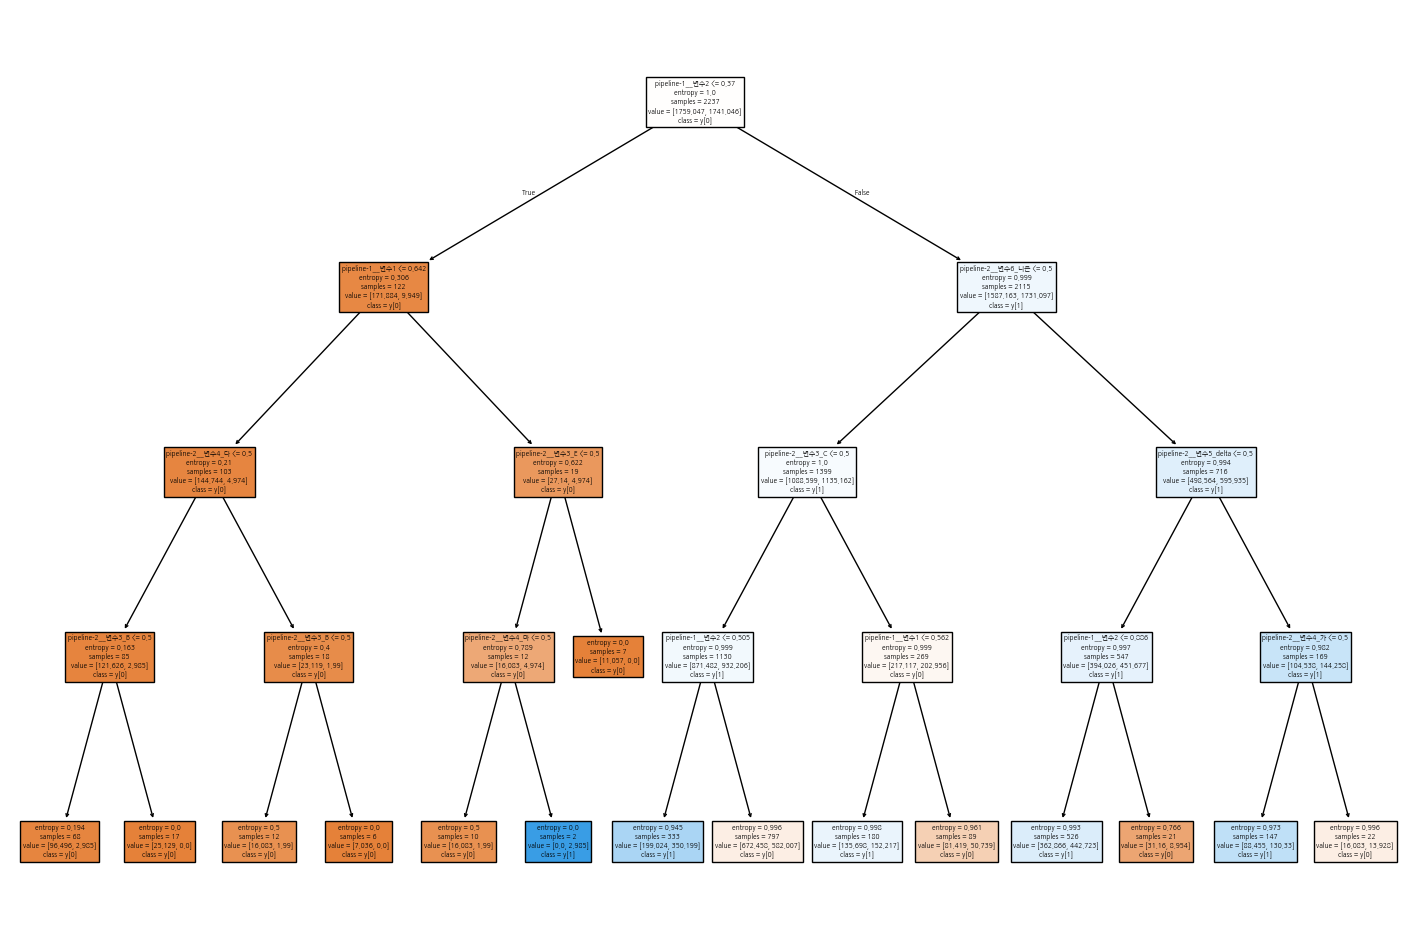

In [52]:
# 트리 모델을 시각화해봅시다.
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.tree import plot_tree

# 시각적 편의를 위해 4개의 노드만 생성했습니다.
plt.figure(figsize=[18,12])
plot_tree(tree1, filled=True, class_names=True, feature_names=bestModel2['columntransformer'].get_feature_names_out())
plt.show()

**변수 중요도 (Variable Importance)** 와 **순열 중요도 (Permutation Importance)** 는 머신러닝 모델에서 피처의 중요도를 평가하는 두 가지 방법입니다. 이 두 방법은 피처가 모델 예측에 얼마나 기여하는지를 측정하지만, 그 접근 방식과 해석에는 차이가 있습니다. 각각의 개념과 계산 방법을 구체적으로 설명하고, 공통점과 차이점을 표로 정리하겠습니다.

## 변수 중요도 (Variable Importance)

- **개념**: 변수 중요도는 주로 결정 트리 기반 모델에서 사용되며, 각 피처가 노드 분할에 얼마나 기여했는지를 기준으로 중요도를 평가합니다. 이는 모델 학습 과정에서 자동으로 계산되며, 피처가 불순도를 얼마나 감소시키는지에 따라 중요도가 결정됩니다.
  
- **계산 방법**:
  - **Mean Decrease in Impurity (MDI)**: 각 피처가 노드 분할 시 불순도를 얼마나 줄였는지를 평균하여 계산합니다.
  - **Gini Importance**: Gini 불순도를 기준으로 측정합니다. 트리의 각 노드에서 선택된 피처가 불순도를 얼마나 감소시켰는지에 따라 중요도를 부여합니다.

## 순열 중요도 (Permutation Importance)

- **개념**: 순열 중요도는 모델 독립적인 방법으로, 특정 피처의 값을 무작위로 섞어 모델의 성능 변화를 측정하여 그 피처의 중요도를 평가합니다. 이는 모델의 예측 성능 변화에 기반하여 각 피처의 기여도를 파악합니다.
  
- **계산 방법**:
  - 특정 피처를 무작위로 섞은 후, 예측 오차가 얼마나 증가하는지를 측정하여 중요도를 산출합니다. 중요한 피처일수록 값을 섞었을 때 모델 성능이 크게 저하됩니다.

## 공통점과 차이점

| **특징**             | **변수 중요도 (Variable Importance)** | **순열 중요도 (Permutation Importance)** |
|----------------------|---------------------------------------|------------------------------------------|
| **모델 의존성**      | 모델 내부에서 계산됨 (주로 트리 기반)  | 모델 독립적                             |
| **계산 방식**        | 노드 분할 시 불순도 감소량 기반       | 특성 무작위 섞기 후 성능 저하 기반      |
| **결과 해석**        | 학습 데이터에 대한 해석 제공          | 테스트 데이터에 대한 해석 가능           |
| **상관관계 영향**    | 상관된 변수 간의 중요도 분산 가능     | 상관된 변수 간 왜곡 가능성 있음          |
| **적용 용이성**      | 트리 기반 모델에서 자동 제공          | 모든 모델에 적용 가능                   |
| **재학습 필요 여부** | 불필요                                 | 불필요                                   |

### 요약

- **변수 중요도(Variable Importance)** 는 트리 기반 모델에서 자동으로 제공되며, 학습 과정에서 피처가 분할에 기여한 정도를 통해 계산됩니다. 이는 빠르고 직관적이지만, 피처 간 상관관계를 고려하지 않습니다.
  
- **순열 중요도(Permutation Importance)** 는 모든 종류의 모델에 적용 가능하며, 피처 값을 무작위로 섞어 성능 변화를 측정하여 평가합니다. 이는 더 많은 정보를 제공하며, 특히 테스트 데이터에 대한 해석이 가능합니다. 그러나 상관관계가 높은 피처들 사이에서는 결과가 왜곡될 수 있습니다.

### Feature Importance
- 변수중요도 먼저 살펴봅시다.

In [53]:
# 변수의 기여도를 확인하기 위해 학습에 사용된 변수 열을 조회해 봅니다.
bestModel2['columntransformer'].transformers_[1][1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

- `bestModel2['columntransformer'].transformers_[1][1]`에서 `[1][1]`인 이유는 `OneHotEncoder()`가 2번째 파이프라인 2번째 위치에 있기 때문.

- `bestModel2.named_steps['columntransformer']`
    - pipeline 객체에서 ColumnTransformer를 가져오는 과정.
- `.transformer_[1][1]`
    - ColumnTransformer 안에 포함된 변환기의 목록을 뜻함.
    - 그 중 첫번째 변환기의 첫번째 객체를 가져오는 것.
- `.named_steps['onehotencoder']`
    - Pipeline 객체의 구조에서 OneHotEncoder 단계를 선택하는 과정입니다.
    - 위에서 가져온 변환기 안에 또 다른 pipeline이 있는 경우 그 내부의 인코더를 가져옵니다.
- `.get_feature_names_out(LIST)`
    - OneHotEncoder로 변환된 열들의 이름을 반환하는 역할을 합니다.
    - `LIST`에는 인코더가 인코딩한 카테고리 열들의 리스트를 넣습니다.
- `.tolist()`
    - 변환된 열 이름들은 기본적으로 넘파이 배열로 되어있는데, 이를 리스트 형태로 변환해줍니다.

In [54]:
encoder_list = bestModel2.named_steps['columntransformer'].\
    transformers_[1][1].\
        named_steps['onehotencoder'].\
            get_feature_names_out(catList).\
                tolist()

# 확인
encoder_list

['변수3_A',
 '변수3_B',
 '변수3_C',
 '변수3_D',
 '변수3_E',
 '변수4_가',
 '변수4_나',
 '변수4_다',
 '변수4_라',
 '변수4_마',
 '변수5_alpha',
 '변수5_bravo',
 '변수5_charlie',
 '변수5_delta',
 '변수6_기역',
 '변수6_니은',
 '변수6_디귿']

#### 잠깐.
- 방금의 과정은 `OneHotEncoder`로 인코딩 된 모델만 적용이 가능해요.
- OneHotEncoder를 적용하지 않았는데 해당 코드를 실행한다면 오류가 발생할 것입니다.

In [55]:
# 방금 만든 encoder_list와 연속형 변수 list와 병합
model_cols_list = X.describe().columns.tolist() + encoder_list

# 확인
print(model_cols_list)

['변수1', '변수2', '변수3_A', '변수3_B', '변수3_C', '변수3_D', '변수3_E', '변수4_가', '변수4_나', '변수4_다', '변수4_라', '변수4_마', '변수5_alpha', '변수5_bravo', '변수5_charlie', '변수5_delta', '변수6_기역', '변수6_니은', '변수6_디귿']


In [56]:
# 변수중요도 출력
bestModel2['randomforestclassifier'].feature_importances_

# 하지만 어떤 열이 얼마나 중요한지 알 수 없음.

array([0.15993563, 0.62234184, 0.01070907, 0.00530158, 0.01922558,
       0.0167296 , 0.01141266, 0.01235029, 0.0146517 , 0.01216536,
       0.00803455, 0.02240955, 0.01150113, 0.00923341, 0.01066672,
       0.01241174, 0.01396757, 0.01392377, 0.01302827])

In [57]:
# 저장을 위한 비어있는 데이터프레임 생성
df_feature_importances = pd.DataFrame()

# 모델에 사용된 features 입력
df_feature_importances['X'] = model_cols_list

# 위에서 잠깐 본 중요도 삽입
df_feature_importances['importance'] = bestModel2['randomforestclassifier']\
                                        .feature_importances_
# 확인
df_feature_importances

,X,importance
0,변수1,0.159936
1,변수2,0.622342
2,변수3_A,0.010709
3,변수3_B,0.005302
4,변수3_C,0.019226
5,변수3_D,0.016730
6,변수3_E,0.011413
7,변수4_가,0.012350
8,변수4_나,0.014652
9,변수4_다,0.012165


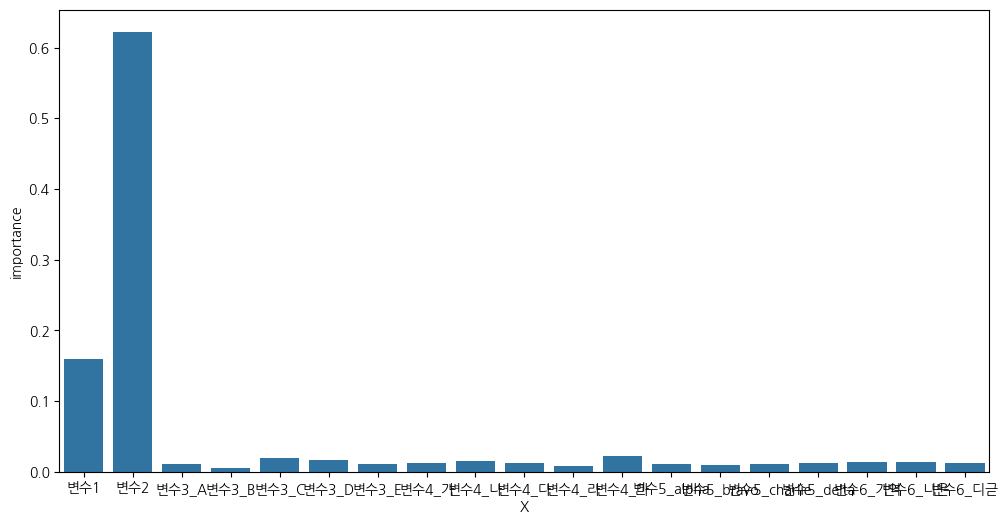

In [58]:
# 시각화

# px.bar(df_feature_importances, x='X', y='importance')
# plotly도 좋지만...

import seaborn as sns
plt.figure(figsize=(12,6))
sns.barplot(df_feature_importances, x='X', y='importance', errorbar=None)
plt.show()

**Permutation Importance**는 머신러닝 모델에서 각 피처의 중요도를 평가하는 방법으로, 피처의 값을 무작위로 섞어 모델 성능이 어떻게 변화하는지를 측정하여 피처의 기여도를 평가합니다. 이 방법은 모델 독립적이어서 다양한 모델에 적용할 수 있지만, 몇 가지 단점도 존재합니다.

## 원리
1. **초기 성능 평가**: 모델이 학습된 후, 테스트 데이터셋을 사용하여 초기 성능(예: 정확도, $R^2$ 등)을 평가합니다. 이를 $P_{\text{initial}}$로 정의합니다.

   $$ P_{\text{initial}} = \text{Model Performance (Initial)} $$

2. **피처 무작위 섞기**: 특정 피처 $X_i$의 값을 무작위로 섞습니다. 이 과정은 피처의 실제 분포를 유지하면서 순서만 변경합니다.

3. **성능 재평가**: 무작위로 섞인 피처를 포함한 데이터셋으로 모델의 성능을 다시 평가합니다. 이를 $P_{\text{scrambled}}$로 정의합니다.

   $$ P_{\text{scrambled}} = \text{Model Performance (With Scrambled } X_i\text{)} $$

4. **성능 변화 계산**: 초기 성능과 무작위로 섞인 피처를 사용한 성능의 차이를 계산하여 피처의 중요도를 평가합니다.

   $$ \Delta P_i = P_{\text{initial}} - P_{\text{scrambled}} $$

   여기서, $\Delta P_i$가 클수록 피처 $X_i$는 모델 성능에 중요한 기여를 한다고 판단할 수 있습니다.

이 수식을 통해 Permutation Importance는 특정 피처의 중요도를 평가하며, 성능 저하가 클수록 해당 피처가 모델에 더 중요한 역할을 한다는 것을 의미합니다.

## 장점

- **모델 독립성**: 어떤 종류의 모델에도 적용할 수 있어 유연성이 높습니다.
- **직관적인 해석**: 성능 저하를 통해 피처의 중요도를 직관적으로 이해할 수 있습니다.

## 단점

- **계산 비용**: 피처를 하나씩 무작위로 섞어가며 성능을 평가하기 때문에 시간이 오래 걸릴 수 있습니다.
- **상관관계 문제**:
  - *중복 정보*: 상관관계가 높은 두 피처가 모두 중요할 경우, 하나의 피처만으로 설명이 가능하다고 잘못 판단하여 중요도가 낮게 평가될 수 있습니다.<br>예를 들어, 스트레스 관리와 수면의 질 예측에서 '수면 시간'과 '피로도'는 상관관계가 높아 하나만으로 설명이 가능하다고 오해할 수 있습니다.
  - *과소평가*: 두 피처를 동시에 고려해야 의미 있는 경우가 있습니다.<br>예를 들어, 학습 성과 예측에서 '카페에 있는 시간'과 '공부 집중도'는 함께 고려해야 의미가 있지만, 개별적으로는 중요도가 낮게 평가될 수 있습니다.

Permutation Importance는 피처의 개별 기여도를 평가하는 데 효과적이지만, 상관관계가 높은 피처들 간의 관계나 복합적인 상호작용을 충분히 반영하지 못할 수 있으므로 해석 시 주의가 필요합니다.

#### `permutation_importance` 함수의 작동 원리

- **estimator**: 이 함수는 이미 학습된(estimator) 모델을 필요로 합니다. 즉, 모델이 데이터를 통해 학습된 상태여야 합니다.
  
- **X**: 이 데이터셋은 모델을 학습할 때 사용된 데이터셋일 수도 있고, 별도로 떼어 놓은 검증용 데이터셋일 수도 있습니다.

- **Permutation Importance 계산 과정**:
  1. **기준 메트릭 평가**: 먼저, 주어진 `X` 데이터셋에서 기준 메트릭(예: 정확도, $R^2$ 등)을 평가합니다. 이 기준 메트릭은 `scoring` 파라미터에 의해 정의됩니다.
  
  2. **피처 열 섞기**: 검증용 데이터셋에서 하나의 피처 열을 무작위로 섞습니다.
  
  3. **메트릭 재평가**: 피처를 섞은 후, 다시 메트릭을 평가합니다.
  
  4. **Permutation Importance 정의**: 기준 메트릭과 피처를 섞은 후의 메트릭 간의 차이를 Permutation Importance로 정의합니다. 이 차이가 클수록 해당 피처가 모델 성능에 중요한 기여를 했다고 판단할 수 있습니다.

In [59]:
# PI를 위한 라이브러리 가져오기
from sklearn.inspection import permutation_importance
# 쉽게말해, 1) 모델, 2) 검증에 사용할 X, 3) 검증에 사용할 Y, 4), 얼마나 반복할 것인지, 5) 기타 인자 입력
result = permutation_importance(bestModel2, x_train, y_train, n_repeats=3, random_state=42)
# 딕셔너리 형태로 반환
result

{'importances_mean': array([0.02733333, 0.07590476, 0.01866667, 0.028     , 0.01885714,
        0.01390476]),
 'importances_std': array([0.0033833 , 0.00026937, 0.00410961, 0.00435812, 0.00084112,
        0.00331833]),
 'importances': array([[0.03142857, 0.02742857, 0.02314286],
        [0.07571429, 0.07571429, 0.07628571],
        [0.01714286, 0.01457143, 0.02428571],
        [0.02314286, 0.02714286, 0.03371429],
        [0.018     , 0.02      , 0.01857143],
        [0.012     , 0.01857143, 0.01114286]])}

In [60]:
df_permutation_importance = pd.DataFrame()
df_permutation_importance['X'] = X.columns

# 
df_permutation_importance['importance'] = result.importances_mean
df_permutation_importance.sort_values('importance', ascending=False, inplace=True)
df_permutation_importance

,X,importance
1,변수2,0.075905
3,변수4,0.028000
0,변수1,0.027333
4,변수5,0.018857
2,변수3,0.018667
5,변수6,0.013905


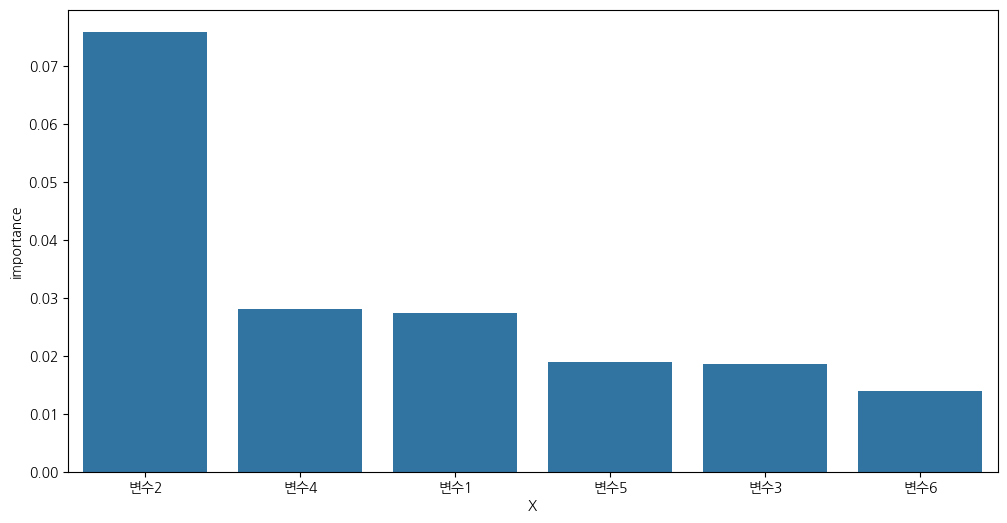

In [61]:
# 시각화

# px.bar(df_permutation_importance, x='X', y='importance')
# plotly도 좋지만...

import seaborn as sns
plt.figure(figsize=(12,6))
sns.barplot(df_permutation_importance, x='X', y='importance', errorbar=None)
plt.show()

**Boosting Model**은 잘못 분류된 데이터에 가중치를 두어 이후의 모델이 오차를 줄여나가는 방식으로 학습하는 기법입니다.<br>
이 방법은 점진적으로 성능을 개선하지만, 시간이 오래 걸리는 것이 단점입니다.<br>
AdaBoost는 이러한 부스팅 모델의 대표적인 예로, 간단한 모델에 적합하며, 이상치나 노이즈가 있는 경우 데이터 전처리가 필요합니다.

## AdaBoost

AdaBoost(Adaptive Boosting)는 여러 약한 학습기(weak learners)를 결합하여 강력한 분류기를 만드는 부스팅 알고리즘입니다.<br>기본적으로 간단한 모델(예: 결정 스텀프)을 사용하여 시작하며, 각 반복에서 잘못 분류된 데이터에 가중치를 부여하여 다음 학습기가 그 오차를 줄이도록 합니다.

### 원리

1. **초기화**: 모든 데이터 포인트에 동일한 가중치를 부여하여 초기 모델을 학습합니다.
2. **반복 학습**:
   - 약한 학습기를 사용하여 데이터셋을 학습합니다.
   - 잘못 분류된 데이터 포인트에 더 높은 가중치를 부여합니다.
   - 새로운 학습기는 이 가중치를 반영하여 학습합니다.
3. **결합**: 각 학습기의 예측을 가중 합산하여 최종 예측을 수행합니다.

### 특징:
   - 이상치 및 노이즈가 있는 경우, 이상치 및 노이즈에 가중치를 부여하기 때문에 데이터를 사전에 처리해두어야 합니다.

### 장점

1. **높은 정확도**: AdaBoost는 모델의 정확도를 향상시키는 데 탁월합니다.<br>이는 특히 이미지 인식, 스팸 탐지, 의료 진단과 같이 높은 정확도가 요구되는 작업에서 효과적입니다.<br>각 약한 학습기의 기여도가 가중치를 통해 조정되며, 최종 모델이 더 높은 정밀도를 달성할 수 있습니다.

2. **과적합에 대한 강건성**: AdaBoost는 일반적으로 과적합에 덜 취약합니다.<br>이는 각 학습 단계에서 잘못 분류된 사례에 집중하여 모델을 개선하는 방식 때문입니다.<br>그러나, 이는 데이터의 특성과 학습기의 선택에 따라 달라질 수 있습니다.

3. **다양한 학습기와 결합 가능**: AdaBoost는 여러 종류의 약한 학습기와 결합할 수 있어 유연성이 높습니다.<br>이는 다양한 데이터와 문제 유형에 적응할 수 있는 능력을 제공합니다.

### 단점

1. **노이즈에 민감함**: AdaBoost는 잘못 분류된 샘플에 높은 가중치를 부여하기 때문에, 노이즈나 이상치가 많은 데이터셋에서는 성능이 저하될 수 있습니다.<br>이는 모델이 노이즈에 지나치게 맞춰져 새로운 데이터에 대한 일반화 능력이 떨어질 수 있음을 의미합니다.

2. **계산 비용**: 부스팅 과정에서 여러 번의 반복 학습이 필요하기 때문에 계산 비용이 높고, 시간이 오래 걸릴 수 있습니다.<br>특히 대규모 데이터셋이나 복잡한 기본 학습기를 사용할 경우 이러한 문제가 두드러질 수 있습니다.

3. **해석의 어려움**: AdaBoost는 여러 약한 학습기의 결합으로 이루어져 있기 때문에, 개별 피처의 기여도를 해석하는 데 어려움이 있을 수 있습니다.<br>이는 모델의 복잡성을 증가시켜 해석 가능성을 낮춥니다.


In [62]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# 데이터 증강을 위한 smote
from imblearn.over_sampling import SMOTE

In [63]:
# 모델 생성
modelPipe2 = make_pipeline(prePipe, SMOTE(), AdaBoostClassifier())
modelPipe2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['변수1', '변수2'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['변수3', '변수4', '변수5', '변수6'], dtype='object'))])),
                ('smote', SMOTE()),
                ('adaboostclassifier', AdaBoostClassifier())])

### 주요 하이퍼파라미터

- **Base Estimator**: 기본 예측 모델로, 일반적으로 깊이가 1인 결정 트리(결정 스텀프)를 사용합니다.
- **n_estimators**: 부스팅 반복 횟수, 즉 약한 학습기의 최대 수를 지정합니다. 값이 크면 성능이 향상될 수 있지만 과적합의 위험도 있습니다.
- **Learning Rate**: 각 약한 학습기의 기여도를 조절하는 파라미터로, 낮은 값은 안정성을 높이고 더 많은 반복이 필요하게 만듭니다.
- **Algorithm**:
  - **SAMME**: 다수의 약한 학습기를 결합하여 강력한 분류기를 만드는 알고리즘입니다.
  - **SAMME.R**: SAMME에서 신뢰도를 기반으로 가중치를 부여하는 변형입니다.

In [64]:
# AdaBoostClassifier의 하이퍼파라미터 튜닝
hp = {
    'adaboostclassifier__n_estimators': [20, 30, 50, 100],
    'adaboostclassifier__learning_rate': [0.01, 0.1, 1, 1.5],
    'adaboostclassifier__algorithm': ['SAMME']
}

gridModel2 = GridSearchCV(modelPipe2,
                          param_grid=hp,
                          n_jobs=-1,
                          cv=3,
                          scoring='f1')

gridModel2.fit(x_train, y_train)

bestModel3 = gridModel2.best_estimator_
bestModel3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['변수1', '변수2'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['변수3', '변수4', '변수5', '변수6'], dtype='object'))])),
                ('smote', SMOTE()),
                ('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME', learning_rate=0.01,
                                    n_estimators=20))])

In [65]:
# 생성한 모델 평가
evaluate_model(bestModel3)

학습성능
              precision    recall  f1-score   support

           0       0.94      0.11      0.19      1741
           1       0.53      0.99      0.69      1759

    accuracy                           0.55      3500
   macro avg       0.74      0.55      0.44      3500
weighted avg       0.73      0.55      0.44      3500

일반화성능
              precision    recall  f1-score   support

           0       0.95      0.11      0.19       760
           1       0.52      0.99      0.68       740

    accuracy                           0.55      1500
   macro avg       0.74      0.55      0.44      1500
weighted avg       0.74      0.55      0.44      1500



**Gradient Boosting**는 Adaptive Boosting의 한계를 극복하기 위해 개발된 모델로, 주로 **잔차(residual)** 를 최소화하는 방식으로 모델의 성능을 점진적으로 개선합니다. 이 방법은 복잡한 데이터에서도 우수한 성능을 발휘하며, 과적합을 조정할 수 있는 다양한 옵션과 규제항을 추가할 수 있다는 장점이 있습니다.

## Gradient Boosting의 특징

1. **잔차 최소화**: Gradient Boosting은 각 단계에서 이전 모델의 예측 오류(잔차)를 줄이는 방향으로 새로운 모델을 학습합니다. 이를 통해 점진적으로 전체 모델의 성능을 향상시킵니다.

2. **과적합 조정**: 다양한 규제 기법과 하이퍼파라미터 튜닝을 통해 과적합을 방지할 수 있습니다. 예를 들어, 트리의 깊이 제한, 학습률 조정, 최소 샘플 분할 크기 설정 등을 통해 모델 복잡성을 제어합니다.

3. **높은 유연성**: 다양한 데이터 구조와 문제 유형에 적응할 수 있으며, 특히 비선형 관계를 잘 포착합니다.

## 주요 하이퍼파라미터

- **n_estimators**: 부스팅 반복 횟수로, 약한 학습기의 최대 수를 지정합니다. 값이 크면 성능이 향상될 수 있지만 과적합의 위험도 있습니다.
- **learning_rate**: 각 학습기의 기여도를 조절하는 파라미터로, 낮은 값은 안정성을 높이고 더 많은 반복이 필요하게 만듭니다.
- **max_depth**: 각 트리의 최대 깊이를 제한하여 모델 복잡성을 제어합니다.
- **subsample**: 각 단계에서 사용할 샘플의 비율을 설정하여 과적합을 방지합니다.

## 장단점

### 장점

- **높은 예측 정확도**: 복잡한 데이터에서도 우수한 성능을 발휘하며, 비선형 관계를 잘 포착합니다.
- **유연성**: 다양한 데이터 구조와 문제 유형에 적응할 수 있습니다.
- **과적합 방지**: *다양한 규제 기법과 하이퍼파라미터 조정을 통해 과적합을 효과적으로 방지할 수 있습니다.*

### 단점

- **계산 비용**: 여러 번의 반복 학습이 필요하기 때문에 계산 비용이 높고 시간이 오래 걸릴 수 있습니다.
- **하이퍼파라미터 튜닝의 복잡성**: 최적의 성능을 위해 많은 하이퍼파라미터를 조정해야 하며, 이는 경험과 실험을 통해 결정해야 합니다.

Gradient Boosting은 이러한 특성 덕분에 금융, 의료, 마케팅 등 다양한 분야에서 널리 사용되고 있으며, 특히 복잡한 데이터 구조와 노이즈가 많은 환경에서 강력한 성능을 발휘합니다.

In [66]:
# 모듈 가져오기
from sklearn.ensemble import GradientBoostingClassifier

Gradient Boosting은 다양한 하이퍼파라미터를 통해 모델의 성능을 조정할 수 있는 강력한 알고리즘입니다. 이 알고리즘은 각 단계에서 잔차를 최소화하여 점진적으로 성능을 향상시킵니다. Gradient Boosting의 주요 하이퍼파라미터와 그 설정 방법을 설명하고, Python 예제를 제시하겠습니다.

## 주요 하이퍼파라미터

1. **loss**: 손실 함수를 지정합니다. 일반적으로 회귀 문제에서는 'squared_error', 분류 문제에서는 'log_loss'를 사용합니다. 
   - 'exponential'은 AdaBoost와 유사한 방식으로 작동합니다.

2. **learning_rate**: 각 트리의 기여도를 축소하는 학습률입니다. 작은 값은 더 많은 트리를 필요로 하지만, 일반적으로 더 나은 일반화 성능을 제공합니다.
   - 일반적인 범위는 0.01에서 0.1 사이입니다.

3. **n_estimators**: 생성할 트리의 수를 지정합니다. 더 많은 트리는 성능을 향상시킬 수 있지만, 과적합의 위험이 있습니다.
   - 일반적으로 100에서 500 사이의 값을 사용합니다.

4. **max_depth**: 개별 트리의 최대 깊이를 설정하여 모델 복잡성을 제어합니다.
   - 작은 값(예: 3-5)은 과적합을 방지하는 데 유리합니다.

5. **subsample**: 각 단계에서 사용할 샘플의 비율을 설정하여 과적합을 방지합니다.
   - 일반적으로 0.5에서 1.0 사이로 설정됩니다.

6. **min_samples_split**: 노드를 분할하기 위한 최소 샘플 수를 지정하여 과적합을 방지합니다.

7. **max_features**: 각 분할에서 고려할 최대 피처 수를 설정합니다.
   - 'auto', 'sqrt', 'log2' 등의 옵션이 있습니다.


In [67]:
hp = {
    'gradientboostingclassifier__n_estimators': [10, 20, 30],
    'gradientboostingclassifier__learning_rate': [0.0001, 0.01],
    'gradientboostingclassifier__max_depth': [4],
    'gradientboostingclassifier__n_iter_no_change':[5],
    'gradientboostingclassifier__subsample': [0.6, 0.8],
    'gradientboostingclassifier__loss': ['log_loss', 'exponential']
}

In [68]:
modelPipe3 = make_pipeline(prePipe, SMOTE(), GradientBoostingClassifier())
gridModel3 = GridSearchCV(modelPipe3, param_grid=hp,
                          cv=2, n_jobs=-1, scoring='f1')
gridModel3.fit(x_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['변수1', '변수2'], dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder...
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__learning_rate': [0.0001,
                                                                       0.01],
                         'gradientboostingclassifier__loss': ['log_loss',
                                                              'exponential'],
                         'gradientboostingclassifier__max_depth': [4],
                         'gradientboostingclassifier__n_estimators': [10, 20,
                                                                      30],
                         'gradientboostingclassifier__n_iter_no_change': [5],
                         'gradientboostingclassifier__subsample': [0.6, 0.8]},
             scoring='f1')

In [69]:
bestModel4 = gridModel3.best_estimator_
# 과적합이 발생했지만..
evaluate_model(bestModel1)

학습성능
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1741
           1       0.50      1.00      0.67      1759

    accuracy                           0.50      3500
   macro avg       0.25      0.50      0.33      3500
weighted avg       0.25      0.50      0.34      3500

일반화성능
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       760
           1       0.49      1.00      0.66       740

    accuracy                           0.49      1500
   macro avg       0.25      0.50      0.33      1500
weighted avg       0.24      0.49      0.33      1500



/opt/anaconda3/envs/hana/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hana/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hana/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/an

XGBoost는 **eXtreme Gradient Boosting**의 약자로, Gradient Boosting 알고리즘을 개선한 머신러닝 기법입니다.

## XGBoost의 주요 특징

- **속도가 빠름**: XGBoost는 기존의 Gradient Boosting에 비해 학습 속도가 빠릅니다. 이는 병렬 처리를 통해 학습 과정을 가속화하기 때문입니다. 특히 대규모 데이터셋에서도 효율적으로 작동하여 시간 절약이 가능합니다.

- **병렬 처리 가능**: XGBoost는 병렬 처리를 지원하여 여러 CPU 코어를 활용해 동시에 여러 작업을 수행할 수 있습니다. 이는 대규모 데이터 처리 시 매우 유리하며, GPU를 활용한 병렬 처리도 가능합니다.

- **히스토그램 기반 알고리즘**: 전통적인 의사결정나무는 모든 데이터 포인트에 대해 분할 기준을 설정하지만, XGBoost는 히스토그램 기반 알고리즘을 사용하여 데이터를 구간으로 묶어 분할합니다. 이는 계산 효율성을 높이고 메모리 사용량을 줄이는 데 기여합니다.

- **L1 및 L2 규제 사용 가능**: XGBoost는 L1(라쏘) 및 L2(릿지) 규제를 통해 모델의 복잡성을 제어하고 과적합을 방지합니다. 이러한 규제는 모델의 일반화 성능을 향상시키는 데 도움을 줍니다.

## 추가적인 고려 사항

- **절대적인 시간 소요**: XGBoost는 상대적으로 빠르지만, 여전히 대규모 데이터셋이나 복잡한 모델에서는 상당한 시간이 소요될 수 있습니다. 이는 하이퍼파라미터 튜닝이나 모델 최적화 과정에서 더욱 두드러질 수 있습니다.

- **해석의 어려움**: XGBoost 모델은 복잡한 결정 트리를 기반으로 하기 때문에, 결과 해석이 어려울 수 있습니다. 특히, 비즈니스 의사결정이나 설명 가능한 AI가 중요한 경우에는 추가적인 해석 도구나 기법이 필요할 수 있습니다.

In [70]:
# 라이브러리 불러오기
from xgboost import XGBClassifier

In [71]:
# 모델 생성
modelPipe4 = make_pipeline(prePipe, XGBClassifier())

XGBoost의 하이퍼파라미터 튜닝은 모델의 성능을 최적화하는 데 중요한 역할을 합니다. 각 하이퍼파라미터는 모델의 복잡성, 학습 속도, 과적합 방지 등에 영향을 미칩니다.

## 주요 하이퍼파라미터

- **learning_rate (학습률)**: 이 파라미터는 각 트리의 가중치 업데이트에 적용되는 학습률을 조절합니다. 값이 작을수록 모델은 더 천천히 학습하지만, 더 많은 트리를 필요로 할 수 있습니다. 일반적으로 작은 값을 사용하여 과적합을 방지하고, 모델의 안정성을 높이는 데 기여합니다.

- **n_estimators (트리 개수)**: 생성할 나무의 개수를 의미합니다. 트리의 수가 많을수록 모델의 복잡성이 증가하며, 과적합의 위험도 커질 수 있습니다. 적절한 트리 개수를 선택하는 것이 중요하며, 보통 `learning_rate`와 함께 조정됩니다.

- **max_depth (최대 깊이)**: 각 결정 트리의 최대 깊이를 설정합니다. 깊이가 깊을수록 모델은 더 복잡해지고 데이터에 대한 세부 사항을 더 잘 학습할 수 있지만, 과적합의 위험도 증가합니다. 데이터 특성에 맞게 적절한 깊이를 선택해야 합니다.

- **reg_alpha (L1 정규화 가중치)**: L1 정규화를 위한 가중치로, 모델의 복잡성을 줄이고 과적합을 방지하는 데 사용됩니다. 높은 값일수록 더 많은 가중치를 0으로 만들며, 이는 변수 선택 효과를 가져옵니다.

- **reg_lambda (L2 정규화 가중치)**: L2 정규화를 위한 가중치로, 모델의 가중치를 부드럽게 조정하여 과적합을 방지합니다. L2 정규화는 모든 가중치를 작게 만들어 모델의 안정성을 높이는 데 도움을 줍니다.

In [73]:
hp = {
    'xgbclassifier__n_estimators':(100, 200),
    'xgbclassifier__learning_rate':(0.01, 0.1, 1.5),
    'xgbclassifier__max_depth':(3, 10)
}

gridModel4 = GridSearchCV(modelPipe4, param_grid=hp, cv=5, scoring='f1', n_jobs=-1)
gridModel4.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['변수1', '변수2'], dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': (0.01, 0.1, 1.5),
                         'xgbclassifier__max_depth': (3, 10),
                         'xgbclassifier__n_estimators': (100, 200)},
             scoring='f1')

In [74]:
bestModel5 = gridModel4.best_estimator_
evaluate_model(bestModel5)

학습성능
              precision    recall  f1-score   support

           0       0.66      0.51      0.57      1741
           1       0.60      0.75      0.67      1759

    accuracy                           0.63      3500
   macro avg       0.63      0.63      0.62      3500
weighted avg       0.63      0.63      0.62      3500

일반화성능
              precision    recall  f1-score   support

           0       0.71      0.52      0.60       760
           1       0.61      0.78      0.68       740

    accuracy                           0.65      1500
   macro avg       0.66      0.65      0.64      1500
weighted avg       0.66      0.65      0.64      1500



LightGBM(Light Gradient Boosting Machine)은 Gradient Boosting 알고리즘을 개선하여 훨씬 빠른 학습 속도를 제공하는 머신러닝 기법입니다.

## LightGBM의 주요 특징

- **Gradient보다 훨씬 빠름**: LightGBM은 기존의 Gradient Boosting 알고리즘보다 훨씬 빠른 속도를 자랑합니다. 이는 대규모 데이터셋에서도 효율적으로 작동하며, 학습 시간을 크게 단축시킬 수 있습니다.

- **히스토그램 기반 알고리즘**: LightGBM은 히스토그램 기반 알고리즘을 사용하여 데이터를 구간으로 묶어 처리합니다. 이 방법은 메모리 사용량을 줄이고, 계산 속도를 높이는 데 기여합니다.

- **GOSS (Gradient-based One-Side Sampling)**: GOSS는 중요한 샘플들만 학습에 참여시킴으로써 효율성을 높입니다. 이는 전체 데이터셋을 사용하는 대신, 정보량이 많은 샘플에 집중하여 모델의 성능을 유지하면서도 학습 속도를 향상시킵니다.

- **leaf-wise 학습**: LightGBM은 leaf-wise 방식으로 트리를 성장시킵니다. 이는 각 노드에서 가장 큰 손실 감소를 가져오는 리프를 선택하여 성장시키는 방식으로, 특정 중요한 특성에 대해 더 깊이 학습할 수 있게 합니다. 이 방식은 전통적인 level-wise 방식보다 더 적은 수의 노드를 사용하면서도 높은 성능을 제공합니다.

## 추가적인 고려 사항

LightGBM은 그 성능과 효율성 덕분에 대규모 데이터 분석에서 널리 사용되고 있습니다.<br>
특히, 빠른 학습 속도와 낮은 메모리 소비로 인해 실시간 데이터 처리나 대규모 데이터셋을 다루는 문제에서 강력한 도구로 평가받고 있습니다.<br>
그러나 leaf-wise 방식은 과적합의 위험이 있으므로, 적절한 하이퍼파라미터 튜닝이 필요합니다.

# Stacking Model

스태킹(Stacking)은 **여러 모델의 예측을 결합하여 최종 예측을 수행하는 메타 학습 기법**입니다. 이는 특정 알고리즘이 아니라 **구조적 접근 방식**으로, 다양한 모델의 강점을 활용하여 성능을 향상시키는 데 목적이 있습니다.

## Stacking의 구조와 작동 원리

- **다양한 모델의 예측을 결합**: 스태킹은 여러 개의 서로 다른 모델(bestModel1, bestModel2, bestModel3 등)을 사용하여 각각의 예측 확률을 계산합니다. 각 모델은 동일한 훈련 데이터에 대해 예측을 수행하고, 그 결과를 새로운 데이터셋(예: X1, X2, X3)으로 변환합니다.

- **메타 모델(Meta Model)**: 이렇게 생성된 여러 모델의 예측 결과(X1, X2, X3)를 입력으로 받아 최종 예측을 수행하는 또 다른 모델입니다. 메타 모델은 이들 예측 결과를 학습하여 최적의 결합 방법을 찾아냅니다. 이를 통해 개별 모델들이 놓칠 수 있는 패턴을 포착하고, 전체적인 성능을 향상시킬 수 있습니다.

## 장점과 단점

- **장점: 높은 성능**: 스태킹은 다양한 모델의 강점을 결합하기 때문에 단일 모델보다 더 높은 예측 성능을 발휘할 수 있습니다. 특히, 서로 다른 유형의 모델들을 조합함으로써 데이터의 다양한 측면을 반영할 수 있습니다.

- **단점: 해석의 어려움**: 스태킹은 여러 모델과 메타 모델이 결합된 복잡한 구조를 가지기 때문에, 결과 해석이 어렵습니다. 각 모델이 어떻게 기여했는지 명확히 알기 힘들며, 이는 설명 가능한 AI가 필요한 상황에서는 단점이 될 수 있습니다.

In [79]:
# 앞서 만든 모델을 활용하여 메타 모델을 생성합니다.
meta_train = pd.DataFrame()
meta_train['model1'] = pd.DataFrame(bestModel1.predict_proba(x_train))[0]
meta_train['model2'] = pd.DataFrame(bestModel2.predict_proba(x_train))[0]
meta_train['model3'] = pd.DataFrame(bestModel3.predict_proba(x_train))[0]
meta_train['model4'] = pd.DataFrame(bestModel4.predict_proba(x_train))[0]
meta_train['model5'] = pd.DataFrame(bestModel5.predict_proba(x_train))[0]
meta_train.head()

,model1,model2,model3,model4,model5
0,0.472,0.480408,0.119203,0.490021,0.492694
1,0.472,0.479182,0.119203,0.490021,0.492694
2,0.472,0.487709,0.119203,0.490021,0.492694
3,0.472,0.423274,0.119203,0.452384,0.390552
4,0.472,0.448785,0.119203,0.490021,0.492694


In [80]:
# 동일하게 평가 데이터도 생성해야 합니다.
meta_test = pd.DataFrame()
meta_test['model1'] = pd.DataFrame(bestModel1.predict_proba(x_test))[0]
meta_test['model2'] = pd.DataFrame(bestModel2.predict_proba(x_test))[0]
meta_test['model3'] = pd.DataFrame(bestModel3.predict_proba(x_test))[0]
meta_test['model4'] = pd.DataFrame(bestModel4.predict_proba(x_test))[0]
meta_test['model5'] = pd.DataFrame(bestModel5.predict_proba(x_test))[0]
meta_test.head()

,model1,model2,model3,model4,model5
0,0.472,0.495312,0.119203,0.490021,0.492694
1,0.472,0.785855,0.880797,0.638471,0.792767
2,0.472,0.484439,0.119203,0.499749,0.492694
3,0.472,0.475656,0.119203,0.514437,0.442793
4,0.472,0.490369,0.119203,0.490021,0.492694


## 추천 메타 모델 알고리즘

- **선형 회귀(Linear Regression)**: 간단하고 해석이 용이하며, 베이스 모델의 예측 결과가 선형 결합으로 잘 설명될 수 있을 때 효과적입니다.

- **로지스틱 회귀(Logistic Regression)**: 이진 분류 문제에서 자주 사용되며, 확률 기반의 결과를 제공할 수 있습니다. 이는 베이스 모델의 출력이 확률일 때 유용합니다.

- **서포트 벡터 머신(Support Vector Machine, SVM)**: 비선형 관계를 잘 포착할 수 있으며, 다양한 커널을 통해 복잡한 패턴을 학습할 수 있습니다. 연구에서는 SVM이 메타 모델로 사용되어 높은 성능을 보이는 사례가 많습니다[3].

- **랜덤 포레스트(Random Forest)**: 비선형성과 복잡한 상호작용을 잘 처리할 수 있으며, 과적합에 강한 특성을 가집니다. 이는 다양한 베이스 모델의 예측 결과를 종합하는 데 유리합니다.

- **XGBoost 또는 LightGBM**: 강력한 성능을 가진 부스팅 알고리즘으로, 메타 모델로 사용 시 높은 예측 정확도를 제공할 수 있습니다. 특히, 대규모 데이터셋에서 효율적입니다[1][2].

## 메타 모델의 복잡도 고려 사항

- **복잡도가 높은 경우**:
  - **장점**: 복잡한 메타 모델은 베이스 모델의 예측 결과 간의 비선형 관계나 복잡한 상호작용을 잘 포착할 수 있습니다. 이는 다양한 베이스 모델의 예측을 더 정교하게 결합하여 성능을 향상시킬 수 있습니다.
  - **단점**: 과적합의 위험이 증가할 수 있습니다. 특히, 베이스 모델의 예측 결과가 이미 충분히 설명력이 있는 경우, 복잡한 메타 모델은 불필요하게 복잡성을 추가할 수 있습니다.

- **복잡도가 낮은 경우**:
  - **장점**: 단순한 메타 모델은 과적합의 위험을 줄이고, 결과 해석이 용이합니다. 베이스 모델이 이미 충분히 다양한 패턴을 학습한 경우, 단순한 메타 모델이 더 적합할 수 있습니다.
  - **단점**: 데이터 간의 복잡한 관계를 충분히 포착하지 못할 수 있으며, 이로 인해 최적의 성능을 발휘하지 못할 가능성이 있습니다.

메타 모델의 복잡도는 **데이터 특성과 문제 유형에 맞춰 조정**되어야 합니다. 일반적으로, 베이스 모델이 다양한 알고리즘으로 구성되어 충분한 다양성을 제공한다면, 메타 모델은 단순한 알고리즘(예: 선형 회귀)을 사용하는 것이 좋습니다.<br>
반면에, 베이스 모델 간의 상호작용이 복잡하고 이를 잘 포착해야 할 필요가 있다면, 더 복잡한 메타 모델(예: 랜덤 포레스트, XGBoost)을 고려해볼 수 있습니다.<br>

<span style="color:red">수업에서는 메타 모델은 베이스 모델보다 복잡해서는 안된다고 배웠습니다!</span>

In [81]:
# 분류 문제였기 때문에, 메타 모델은 분류 모델 중 가벼운 모델 사용
from sklearn.linear_model import LogisticRegression

# 모델 생성
metaModel = LogisticRegression()

In [82]:
# 훈련/검증 데이터 변수 지정
x_meta_train = meta_train.copy()
x_meta_test = meta_test.copy()

In [83]:
# 학습 수행
metaModel.fit(x_meta_train, y_train)

LogisticRegression()

In [86]:
# 평가
y_meta_train_pred = metaModel.predict(x_meta_train)
y_meta_test_pred = metaModel.predict(x_meta_test)

print(classification_report(y_train, y_meta_train_pred))
print(classification_report(y_test, y_meta_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.62      0.64      1741
           1       0.64      0.67      0.66      1759

    accuracy                           0.65      3500
   macro avg       0.65      0.65      0.65      3500
weighted avg       0.65      0.65      0.65      3500

              precision    recall  f1-score   support

           0       0.66      0.61      0.63       760
           1       0.63      0.68      0.65       740

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0.64      1500
weighted avg       0.64      0.64      0.64      1500



Citations:
- https://koreascience.kr/article/JAKO202211954995024.pdf
- https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002330397
- https://arxiv.org/abs/2104.02395
- https://swingswing.tistory.com/281
- https://modulabs.co.kr/blog/model-ensembling-guide/
- https://scienceon.kisti.re.kr/srch/selectPORSrchArticle.do?cn=JAKO201025736638843
- https://ieeexplore.ieee.org/document/9893798
- https://www.restack.io/p/hyperparameter-tuning-answer-bagging-classifier-cat-ai
- https://sklearner.com/scikit-learn-grid-search-baggingclassifier/
- https://dev-with-gpt.tistory.com/60
- https://stackoverflow.com/questions/47570307/tuning-parameters-of-the-classifier-used-by-baggingclassifier
- https://modulabs.co.kr/blog/model-ensembling-guide/
- https://www.geeksforgeeks.org/ml-bagging-classifier/
- https://www.simplilearn.com/tutorials/machine-learning-tutorial/bagging-in-machine-learning
- https://velog.io/@baeyuna97/ML-Ensemble
- https://topo314.tistory.com/81
- https://yeong-jin-data-blog.tistory.com/entry/%EC%95%99%EC%83%81%EB%B8%94-%EA%B8%B0%EB%B2%95Ensemble-Method-Bagging-vs-Boosting
- https://koreascience.kr/article/JAKO202211954995024.pdf
- https://modulabs.co.kr/blog/model-ensembling-guide/
- https://blog.naver.com/gdpresent/221717300058
- https://dev-with-gpt.tistory.com/60
- https://gils-lab.tistory.com/89
- https://www.ibm.com/kr-ko/topics/random-forest
- https://gils-lab.tistory.com/88
- https://aytekin.tistory.com/47
- https://bommbom.tistory.com/entry/%EB%9E%9C%EB%8D%A4-%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8Random-Forest-%EC%9E%A5%EB%8B%A8%EC%A0%90-%ED%8A%B9%EC%84%B1-%EC%A4%91%EC%9A%94%EB%8F%84
- https://heytech.tistory.com/149
- https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8
- https://resultofeffort.tistory.com/107
- https://datasciencediary.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-Random-Forest-%EB%9E%9C%EB%8D%A4-%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8-%EB%AA%A8%EB%8D%B8-%EA%B0%9C%EB%85%90-%EC%9D%B4%ED%95%B4
- https://dev.to/newbie_coder/unleashing-the-potential-of-random-forest-regression-a-python-implementation-guide-with-hyperparameter-tuning-167o
- https://www.restack.io/p/hyperparameter-tuning-answer-bagging-classifier-cat-ai
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74?gi=ffbe69afb49f
- https://www.kdnuggets.com/2022/08/tuning-random-forest-hyperparameters.html
- https://resultofeffort.tistory.com/107
- https://stackoverflow.com/questions/58275113/proper-use-of-class-weight-parameter-in-random-forest-classifier
- https://stackoverflow.com/questions/23939750/understanding-max-features-parameter-in-randomforestregressor/56364415
- https://www.kdnuggets.com/2022/08/tuning-random-forest-hyperparameters.html
- https://notebook.community/Meena-Mani/SECOM_class_imbalance/secomdata_rf
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74?gi=ffbe69afb49f
- https://www.projectpro.io/article/adaboost-algorithm/972
- https://www.oreilly.com/library/view/machine-learning-with/9781789343700/0d1439c3-f90b-4cb3-9e76-0f3cc0dcd6f9.xhtml
- https://en.wikipedia.org/wiki/Adaboost
- https://blog.paperspace.com/adaboost-optimizer/
- https://mljourney.com/adaboost-advantages-and-disadvantages/
- https://en.wikipedia.org/wiki/Adaboost
- https://blog.paperspace.com/adaboost-optimizer/
- https://www.mdpi.com/2227-7390/11/8/1801
- https://www.sciencedirect.com/topics/engineering/adaboost
- https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/31872997/b6e56311-67da-4d27-a01e-c4f6c6f1f5e8/paste.txt
- https://trivia-starage.tistory.com/136
- https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/ensemble/_weight_boosting.py
- https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/31872997/b6e56311-67da-4d27-a01e-c4f6c6f1f5e8/paste.txt
- https://www.datacamp.com/tutorial/guide-to-the-gradient-boosting-algorithm
- https://aiml.com/what-are-the-key-hyper-parameters-for-a-gbm-model/
- https://www.semanticscholar.org/paper/df9e42f30cc4bd637fed1d46b9473cbb3807cae3
- https://www.semanticscholar.org/paper/96693fa1f695d6a02ddbe1c88d068b6663581fa3
- https://www.semanticscholar.org/paper/5b5e972270e29130fb982cc707108c3f2e743c3c
- https://www.semanticscholar.org/paper/192e29acd9baa72806ca3c73070e4a016a32abf0
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10764024/
- https://www.semanticscholar.org/paper/beefb92ec6f255fc5247ceb91d071b8137b2b773
- https://www.semanticscholar.org/paper/50652b337ab5ec4473fb3f716ececebff6988a83
- https://www.semanticscholar.org/paper/078527904e91af48116458d1cd3d41193ea3bed1
- https://www.semanticscholar.org/paper/23de5f0e861277510b92ed30eb23a145a1a988b6